In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test

#### Get the relevant training datasets and combine them to form the full training set with Proteins and Peptides

In [39]:
train_proteins_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')
print(train_proteins_df.shape)
print(train_proteins_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
#train_proteins_df.head(10)

train_peptides_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
print(train_peptides_df.shape)
print(train_peptides_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
#train_peptides_df.head(10)

pro_pep_join = pd.merge(train_proteins_df, train_peptides_df, on=['patient_id','visit_id','visit_month','UniProt'], how='inner')

del train_proteins_df, train_peptides_df
gc.collect()

train_clinical_data_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
print(train_clinical_data_df.shape)
print(train_clinical_data_df.memory_usage(deep=True).sum()/1024/1024, " MBs")

full_training_data = pd.merge(pro_pep_join, train_clinical_data_df, on=['patient_id','visit_id','visit_month'], how='inner')

del pro_pep_join, train_clinical_data_df
gc.collect()

full_training_data = full_training_data.drop(columns=['UniProt','Peptide','upd23b_clinical_state_on_medication','patient_id'])

print(full_training_data.shape)
full_training_data.head(10)

(232741, 5)
33.64677047729492  MBs
(981834, 6)
212.76564979553223  MBs
(2615, 8)
0.3944511413574219  MBs
(941744, 8)


,visit_id,visit_month,NPX,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,0,11254.3,11254.3,10.0,6.0,15.0,NaN
1,55_0,0,732430.0,102060.0,10.0,6.0,15.0,NaN
2,55_0,0,732430.0,174185.0,10.0,6.0,15.0,NaN
3,55_0,0,732430.0,27278.9,10.0,6.0,15.0,NaN
4,55_0,0,732430.0,30838.7,10.0,6.0,15.0,NaN
5,55_0,0,732430.0,23216.5,10.0,6.0,15.0,NaN
6,55_0,0,732430.0,170878.0,10.0,6.0,15.0,NaN
7,55_0,0,732430.0,148771.0,10.0,6.0,15.0,NaN
8,55_0,0,732430.0,55202.1,10.0,6.0,15.0,NaN
9,55_0,0,39585.8,27229.3,10.0,6.0,15.0,NaN


#### Remove the NaNs from the UPDRS test scores, using the mean from within the same group of UPDRS test scores, e.g. NaNs in updrs_4 are filled with mean of updrs_4

In [3]:
full_training_data_melted = full_training_data.melt(id_vars=['visit_id','visit_month','NPX','PeptideAbundance']
                                                    , value_vars=['updrs_1','updrs_2','updrs_3','updrs_4'],var_name='updrs_test', value_name='updrs_test_score')

list_of_updrs_tests = full_training_data_melted.updrs_test.unique()

temp_df = full_training_data_melted.groupby(['updrs_test']).agg(visit_month_per_patient=('visit_id', 'count')
                                                      , mean_updrs_test_score=('updrs_test_score', 'mean') ).reset_index(level=['updrs_test'])

for i in range(len(list_of_updrs_tests)):
    print(list_of_updrs_tests[i])
    updrs_test_mean = full_training_data[list_of_updrs_tests[i]].mean()
    print(updrs_test_mean)
    full_training_data.fillna({list_of_updrs_tests[i]:updrs_test_mean}, inplace=True)

updrs_1
6.506168342989177
updrs_2
5.781904636504188
updrs_3
17.205188800631337
updrs_4
1.8879240409258773


#### Combine all UPDRS scores are one column and creating categorical column of UPDRS tests

In [14]:
full_training_data_melted = full_training_data.melt(id_vars=['visit_id','visit_month','NPX','PeptideAbundance']
                                                    , value_vars=['updrs_1','updrs_2','updrs_3','updrs_4'],var_name='updrs_test', value_name='updrs_test_score')

#full_training_data_melted['group_key'] = full_training_data_melted['visit_month']
#full_training_data_melted['row_id'] = full_training_data_melted['visit_id'] + '_' + full_training_data_melted['updrs_test']

print(full_training_data_melted.updrs_test_score.unique())
print(full_training_data_melted.visit_month.unique())

full_training_data_melted[full_training_data_melted['visit_id']=='55_0']

[10.         11.          2.          1.          8.          6.
  9.         12.          5.          7.          4.         17.
  3.          0.         14.         16.         15.         20.
 18.         13.         33.         28.         25.         26.
 19.         21.         24.         22.         23.         27.
 29.         36.         38.         30.         46.         41.
 40.         39.         47.         32.         31.         34.
 56.         52.         35.         17.2051888  51.         44.
 68.         43.         67.         61.         45.         59.
 37.         48.         42.         60.         55.         49.
 63.         78.         58.         50.         66.          1.88792404]
[  0   3   6  12  18  24  30  36  48  54  60  72  84  96 108]


,visit_id,visit_month,NPX,PeptideAbundance,updrs_test,updrs_test_score
0,55_0,0,11254.3,11254.3,updrs_1,10.000000
1,55_0,0,732430.0,102060.0,updrs_1,10.000000
2,55_0,0,732430.0,174185.0,updrs_1,10.000000
3,55_0,0,732430.0,27278.9,updrs_1,10.000000
4,55_0,0,732430.0,30838.7,updrs_1,10.000000
...,...,...,...,...,...,...
2826158,55_0,0,408698.0,98654.3,updrs_4,1.887924
2826159,55_0,0,408698.0,218723.0,updrs_4,1.887924
2826160,55_0,0,29758.8,29758.8,updrs_4,1.887924
2826161,55_0,0,23833.7,23833.7,updrs_4,1.887924


#### Check for NaNs

In [15]:
full_training_data_melted.isna().sum()

visit_id            0
visit_month         0
NPX                 0
PeptideAbundance    0
updrs_test          0
updrs_test_score    0
dtype: int64

#### Proceed to create a train-test split on the Training dataset, to test out the accuracy of the developed models

<AxesSubplot:>

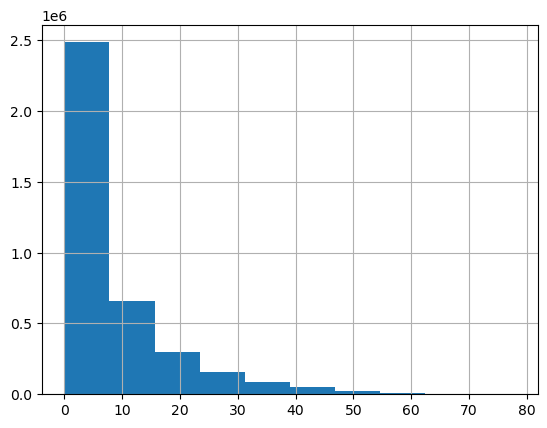

In [16]:
#full_training_data_melted[['updrs_test_score','PeptideAbundance','NPX','group_key']].corr()
full_training_data_melted['updrs_test_score'].hist()

<AxesSubplot:>

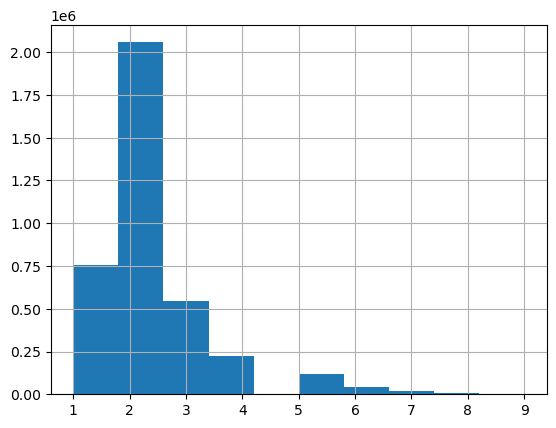

In [17]:
full_training_data_melted['updrs_score_category'] = pd.cut(full_training_data_melted['updrs_test_score'],
                                                          bins=[-np.inf, 0., 10., 20., 30., 40., 50., 60., 70., 80., np.inf],
                                                          labels=[1,2,3,4,5,6,7,8,9,10])

full_training_data_melted['updrs_score_category'].hist()

#### Check if there are any NaNs in the created bins, there shouldn't be any

In [10]:
full_training_data_melted['updrs_score_category'].unique()
#full_training_data_melted[full_training_data_melted['updrs_score_category'].isna()]
#full_training_data_melted[full_training_data_melted['updrs_test_score'] < 0]

[2, 3, 1, 5, 4, 6, 7, 8, 9]
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

In [18]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(full_training_data_melted, full_training_data_melted['updrs_score_category']):
    strat_train_set = full_training_data_melted.loc[train_index]
    strat_test_set = full_training_data_melted.loc[test_index]

#### Now, let's verify the percentage distribution of the data in the train and test splits, they should be very close

In [19]:
strat_test_set['updrs_score_category'].value_counts()/len(strat_test_set)

2     0.546203
1     0.201293
3     0.144421
4     0.058847
5     0.030969
6     0.011998
7     0.004732
8     0.001306
9     0.000232
10    0.000000
Name: updrs_score_category, dtype: float64

In [20]:
strat_train_set['updrs_score_category'].value_counts()/len(strat_train_set)

2     0.546202
1     0.201293
3     0.144421
4     0.058847
5     0.030969
6     0.011997
7     0.004731
8     0.001307
9     0.000232
10    0.000000
Name: updrs_score_category, dtype: float64

In [14]:
print(strat_train_set.shape)
print(strat_test_set.shape)

(3013580, 7)
(753396, 7)


#### Get rid of the unwanted column which was created to assist in the splitting process

In [21]:
strat_train_set = strat_train_set.drop(columns=['updrs_score_category'])
strat_test_set = strat_test_set.drop(columns=['updrs_score_category'])
strat_train_set.head(10)

,visit_id,visit_month,NPX,PeptideAbundance,updrs_test,updrs_test_score
2846225,10718_0,0,2511280.0,175969.00,updrs_4,0.000000
449723,16347_24,24,51674.1,42613.80,updrs_1,3.000000
3111634,16566_12,12,904164.0,151785.00,updrs_4,5.000000
3242217,3636_24,24,4037500.0,677633.00,updrs_4,1.887924
243261,59574_6,6,71899.7,71899.70,updrs_1,0.000000
3162961,37220_12,12,9267080.0,152006.00,updrs_4,1.887924
3591060,35231_48,48,1387630.0,3609.76,updrs_4,0.000000
2257379,54979_12,12,3518430.0,87876.50,updrs_3,31.000000
2683914,57009_48,48,592419.0,69920.90,updrs_3,0.000000
408644,15504_18,18,60624.7,41237.70,updrs_1,5.000000


<AxesSubplot:xlabel='PeptideAbundance', ylabel='updrs_test_score'>

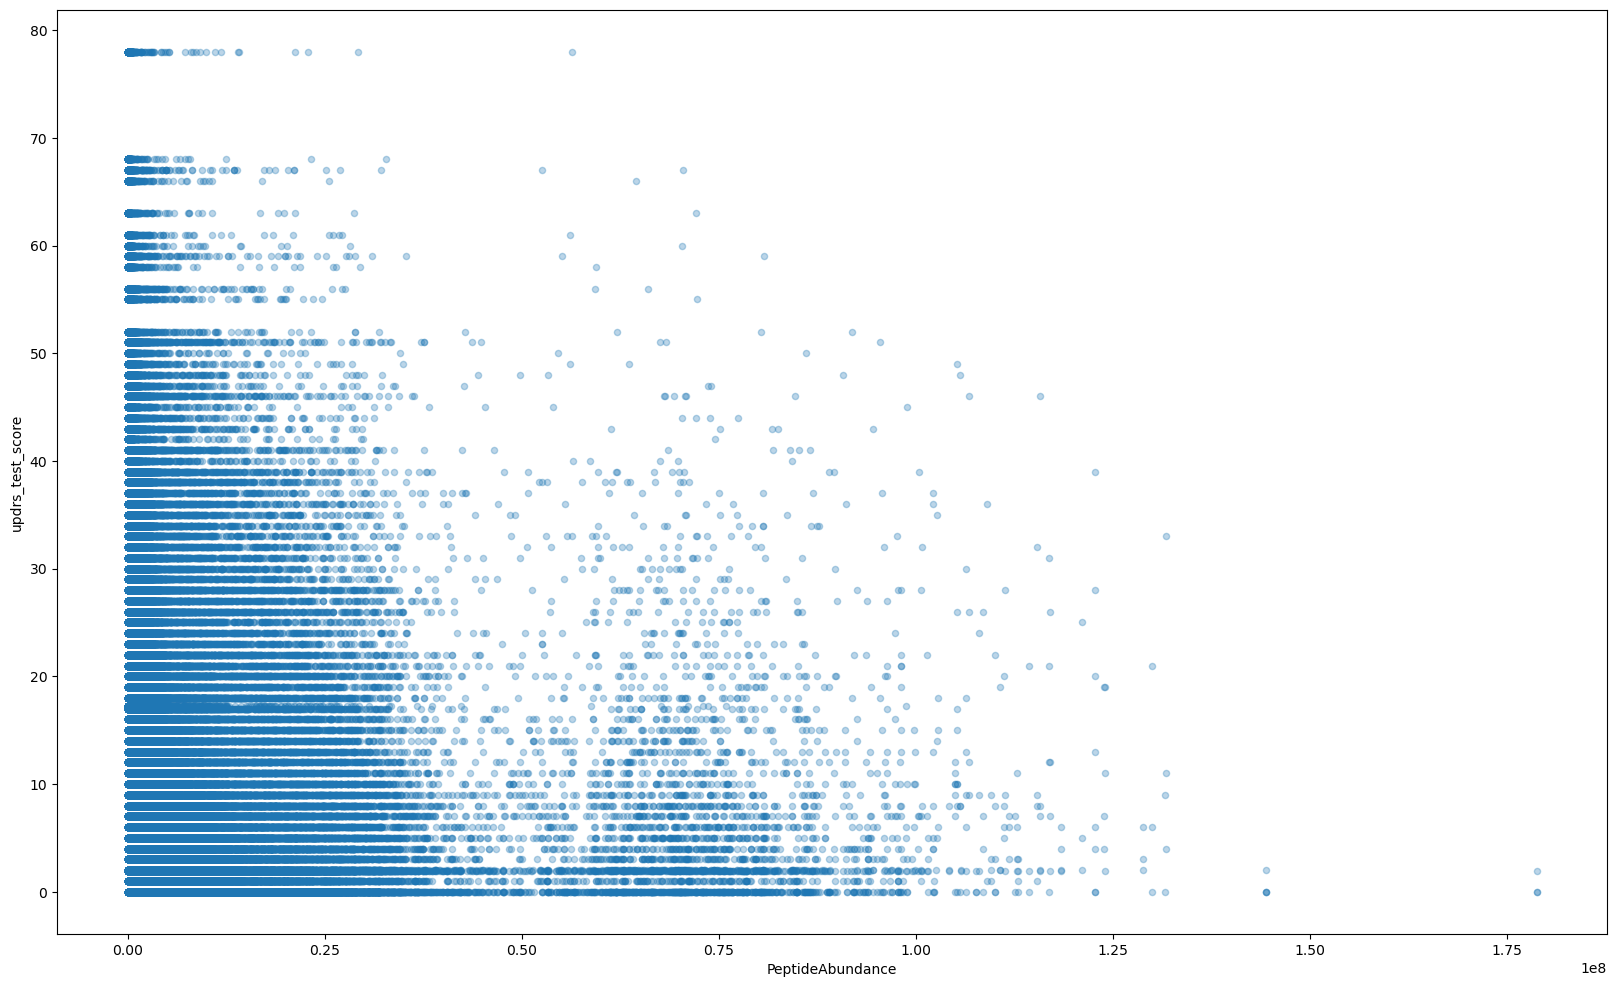

In [31]:
strat_train_set.plot(kind="scatter", x="PeptideAbundance", y="updrs_test_score", alpha=0.3, figsize=(20,12))

#### Now let us separate the labels and numeric, categorical attributes so that we can build the scikit learn pipelines

In [22]:
strat_train_set_wo_labels = strat_train_set.drop('updrs_test_score', axis=1)
strat_train_set_labels = strat_train_set['updrs_test_score'].copy()
strat_train_set_numeric = strat_train_set_wo_labels.drop(columns=['visit_id','visit_month','updrs_test'])
strat_train_set_cat = strat_train_set_wo_labels[['visit_month','updrs_test']]

strat_test_set_wo_labels = strat_test_set.drop('updrs_test_score', axis=1)
strat_test_set_labels = strat_test_set['updrs_test_score'].copy()

del full_training_data, full_training_data_melted
gc.collect()

7371

In [23]:
from sklearn.preprocessing import StandardScaler

numeric_pipeline = Pipeline([
    ('standard_scaler', StandardScaler())
])

numeric_attributes = list(strat_train_set_numeric)
categorical_attributes = list(strat_train_set_cat)

full_pipeline = ColumnTransformer([
    ('num', numeric_pipeline, numeric_attributes),
    ('cat', OneHotEncoder(), categorical_attributes)
])

strat_train_set_prepared = full_pipeline.fit_transform(strat_train_set_wo_labels)
strat_test_set_prepared = full_pipeline.fit_transform(strat_test_set_wo_labels)

#### Train the Linear Regression model

In [25]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg_model = lin_reg.fit(strat_train_set_prepared, strat_train_set_labels)

#### Test if the model is actually churning out predictions

In [26]:
some_data = strat_train_set_wo_labels.iloc[:5]
some_labels = strat_train_set_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions: ', lin_reg_model.predict(some_data_prepared))
print('Labels: ', list(some_labels))

Predictions:  [0.06457829 6.36146307 1.49867592 1.74441706 8.74696716]
Labels:  [0.0, 3.0, 5.0, 1.8879240409258773, 0.0]


### Testing the RMSE
#### RMSE <= 0.75 : Very good accuracy | 0.75 < RMSE <= 1.0 : Good accuracy

#### First on train data (train split from the full training dataset)

In [27]:
train_df_predictions = lin_reg_model.predict(strat_train_set_prepared)
mse = mean_squared_error(strat_train_set_labels, train_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

8.439416662701587


#### 2nd on test data (test split from the full training dataset)

In [28]:
test_df_predictions = lin_reg_model.predict(strat_test_set_prepared)
mse = mean_squared_error(strat_test_set_labels, test_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

8.429213893643048


#### Since Linear Regression model is very poor on both train and test data, let's try out Polynomial model of degree 3

In [59]:
numeric_pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('poly',PolynomialFeatures(degree=2, include_bias=False))
])

numeric_attributes = list(strat_train_set_numeric)
categorical_attributes = list(strat_train_set_cat)

full_pipeline = ColumnTransformer([
    ('num', numeric_pipeline, numeric_attributes),
    ('cat', OneHotEncoder(), categorical_attributes)
])

strat_train_set_prepared = full_pipeline.fit_transform(strat_train_set_wo_labels)
strat_test_set_prepared = full_pipeline.fit_transform(strat_test_set_wo_labels)

In [44]:
poly_reg = LinearRegression()

poly_reg_model = poly_reg.fit(strat_train_set_prepared, strat_train_set_labels)

In [45]:
train_df_predictions = poly_reg_model.predict(strat_train_set_prepared)
mse = mean_squared_error(strat_train_set_labels, train_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

8.439114935316727


In [46]:
test_df_predictions = poly_reg_model.predict(strat_test_set_prepared)
mse = mean_squared_error(strat_test_set_labels, test_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

8.428790289314087


#### No joy on polynomial model, trying out Decision Tree regression on polynomial features

In [ ]:
#from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg_model = tree_reg.fit(strat_train_set_prepared, strat_train_set_labels)

In [56]:
train_df_predictions = tree_reg_model.predict(strat_train_set_prepared)
mse = mean_squared_error(strat_train_set_labels, train_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

0.5280460759328438


In [57]:
test_df_predictions = tree_reg_model.predict(strat_test_set_prepared)
mse = mean_squared_error(strat_test_set_labels, test_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

11.951220943268494


#### Looks like decision tree with 5 degree polynomial features are overfitting